## Dataframe and libraries Import

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.python.client import device_lib


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2021-12-16 19:48:21.557322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 19:48:21.647863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 19:48:21.648554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 19:48:21.651062: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
import pandas as pd

df = pd.read_csv('../input/movie-classification/movie_dataset_classification.csv',index_col=0)
df.dropna(subset=['Plot'], inplace=True)
df.drop_duplicates(subset=['Title','Plot'], inplace=True)
#removing low frequency genres
counts = df.Genre.value_counts()
counts = list(counts[counts < 150].index)
df = df[~df['Genre'].isin(counts)]

## Preprocessing

In [3]:
df['Genre'].value_counts()

drama              8098
comedy             6501
adventure          2818
science fiction    2719
western            2660
thriller           2516
action             2116
musical            1827
noir               1713
horror             1355
romance            1332
fantasy             827
animation           811
war                 534
sport               409
documentary         354
family              319
historical          253
biography           219
Name: Genre, dtype: int64

In [4]:
def transform_genres(genre):
    if genre in ['action', 'adventure']:
        return 'action & adventure'
        
    elif genre == 'biography':
        return 'documentary'

    elif genre in ['science fiction', 'fantasy']:
        return 'sci-fi & fantasy'
        
    elif genre == 'noir':
        return 'thriller'
    
    return genre

In [5]:
df['Genre'] = df['Genre'].apply(transform_genres)

In [6]:
ids = df[df['Genre'].isin(['drama', 'comedy', 'thriller'])]['Genre'].sample(frac=0.2, random_state=2).index
df_1 = df[~df['Genre'].isin(['drama', 'comedy', 'thriller'])]
df_2 = df.loc[ids,:]

In [7]:
df = pd.concat([df_1,df_2],axis=0)
df['Genre'].value_counts()

action & adventure    4934
sci-fi & fantasy      3546
western               2660
musical               1827
drama                 1630
horror                1355
romance               1332
comedy                1287
thriller               849
animation              811
documentary            573
war                    534
sport                  409
family                 319
historical             253
Name: Genre, dtype: int64

## Tokenization

In [8]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 8000
maxlen = 300
embedding_dims = 300
hidden_dims = 20

X = df['Plot'].values

Building vocabulary with nltk

In [9]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen, truncating='post')

In [10]:
len(tokenizer.word_index)

133705

In [11]:
from collections import OrderedDict
dictionary = dict(OrderedDict(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)))

In [12]:
vocab = {x:y for i,(x, y) in enumerate(dictionary.items()) if i < max_features }

In [13]:
len(vocab)

8000

## Embedding

In [14]:
glove_emb_link = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"

In [15]:
from io import StringIO, BytesIO, TextIOWrapper
from zipfile import ZipFile
from urllib.request import urlopen
import requests

resp = requests.get(glove_emb_link)

In [16]:
embeddings_index = dict()

with ZipFile(BytesIO(resp.content),'r') as zipfile:
    with TextIOWrapper(zipfile.open("glove.6B.300d.txt"), encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [17]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_features, embedding_dims))
try:
    for word in vocab.keys():
        i = tokenizer.word_index[word]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
except:
    pass

In [18]:
len(embedding_matrix)

8000

In [19]:
resp = None

## Classification

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y = np.array(df['Genre'].values)
n_labels = len(set(y))

label_encoder = LabelEncoder()
y = np.array(label_encoder.fit_transform(y))

cat_y = to_categorical(y, num_classes=n_labels)

X_train, X_test, y_train, y_test = train_test_split(X, cat_y, test_size=0.20, stratify=cat_y)

import numpy as np 

sample_idx = 0
y_train_bin = np.asarray(y_train)==y_train[sample_idx]
y_test_bin = np.asarray(y_test)==y_train[sample_idx]
y_train_bin,y_test_bin

#### Class weights

In [21]:
n_classes = len(label_encoder.classes_)
n_samples = X.shape[0]
value_counts = df['Genre'].value_counts().sort_index().items()

class_weights = { i: n_samples / (n_classes * freq ) for i,(_,freq) in enumerate(value_counts) }
class_weights

{0: 0.30156735576273475,
 1: 1.8346896835182902,
 2: 1.1561253561253562,
 3: 2.59674229203025,
 4: 0.9128425357873211,
 5: 4.664367816091954,
 6: 5.881159420289855,
 7: 1.0981057810578105,
 8: 0.8144134282065316,
 9: 1.117067067067067,
 10: 0.41960894905057344,
 11: 3.6379788101059494,
 12: 1.7525716529250097,
 13: 2.7863920099875155,
 14: 0.5593734335839599}

### LSTM

In [22]:
from tensorflow.keras.optimizers import Adam, schedules

e = Embedding(max_features,
              embedding_dims, 
              weights=[embedding_matrix], 
              input_length=maxlen, 
              trainable=False)

model = Sequential()
model.add(e)
model.add(SpatialDropout1D(0.3))
model.add(LSTM(hidden_dims, dropout=0.3))
model.add(Dense(n_labels, activation='softmax'))

opt = Adam(learning_rate=0.01)

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          2400000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                25680     
_________________________________________________________________
dense (Dense)                (None, 15)                315       
Total params: 2,425,995
Trainable params: 25,995
Non-trainable params: 2,400,000
_________________________________________________________________


In [23]:
batch_size = 512
epochs = 50
print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          validation_split=0.15)
          #class_weight=class_weights)

Train...
Epoch 1/50


2021-12-16 19:49:42.598233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-16 19:49:44.941650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


30/30 [==============================] - 5s 51ms/step - loss: 2.4054 - accuracy: 0.2169 - val_loss: 2.3296 - val_accuracy: 0.2445
Epoch 2/50
30/30 [==============================] - 1s 36ms/step - loss: 2.1281 - accuracy: 0.3168 - val_loss: 1.9318 - val_accuracy: 0.3860
Epoch 3/50
30/30 [==============================] - 1s 33ms/step - loss: 1.7754 - accuracy: 0.4436 - val_loss: 1.6318 - val_accuracy: 0.4879
Epoch 4/50
30/30 [==============================] - 1s 34ms/step - loss: 1.5953 - accuracy: 0.4939 - val_loss: 1.5306 - val_accuracy: 0.5136
Epoch 5/50
30/30 [==============================] - 1s 34ms/step - loss: 1.5130 - accuracy: 0.5166 - val_loss: 1.4787 - val_accuracy: 0.5248
Epoch 6/50
30/30 [==============================] - 1s 34ms/step - loss: 1.4777 - accuracy: 0.5287 - val_loss: 1.4694 - val_accuracy: 0.5312
Epoch 7/50
30/30 [==============================] - 1s 34ms/step - loss: 1.4422 - accuracy: 0.5405 - val_loss: 1.4439 - val_accuracy: 0.5420
Epoch 8/50
30/30 [======

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
y_preds = model.predict(X_test)
prediction = np.argmax(y_preds,axis=1)
ground_truth = np.argmax(y_test, axis=1)
accuracy_score(ground_truth,prediction)

0.5770609318996416

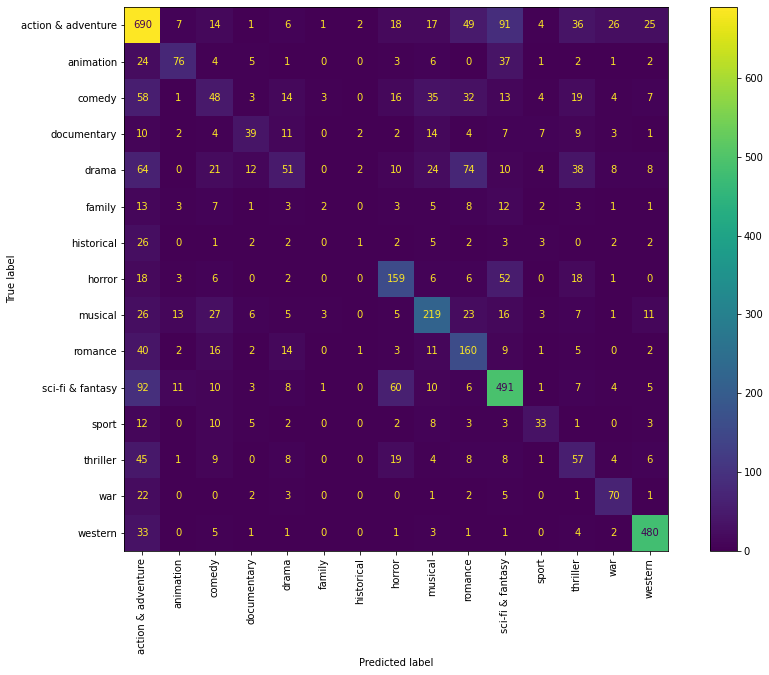

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(15, 10))
cm = confusion_matrix(ground_truth, prediction, labels=list(set(ground_truth)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.show()

## IMDB dataset

In [26]:
df_imdb = pd.read_csv('../input/imdb-movies-genres/imdb_dataset.csv',usecols=['title','genres'])
df_imdb

,title,genres
0,Carmencita,"Documentary,Short"
1,The Clown and His Dogs,"Animation,Short"
2,Blacksmithing Scene,"Comedy,Short"
3,Chinese Opium Den,Short
4,Corbett and Courtney Before the Kinetograph,"Short,Sport"
...,...,...
1200371,The Copeland Case,Drama
1200372,Loving London: The Playground,"Drama,Short"
1200373,The Demonic Nun,"Comedy,Horror,Mystery"
1200374,Pretty Pretty Black Girl,Short
